## AdaBoost Implementation

Implementation of AdaBoost with "optimal" decision stumps on the training data. After each round, the following gets computed:
1. Current training error for the weighted linear combination predictor at this round
2. Current testing error for the weighted linear combination predictor at this round
3. Current test AUC for the weighted linear combination predictor at this round
4. The local "round" error for the decision stump returned

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

### Implementing AdaBoost

In [2]:
# AdaBoost
class AdaBoost:
    def __init__(self, iterations):
        self.train_df = None
        self.test_df = None
        self.train_labels = None
        self.test_labels = None
        self.train_predictions = None
        self.test_predictions = None
        self.thresholds_dict = None
        self.train_hx_dict = None
        self.columnname = None
        self.colsplitvalue = None
        self.epsilon = None
        self.alpha = None
        self.D = None
        self.trueClass = None
        self.falseClass = None
        self.train_H = None
        self.test_H = None
        self.iterations = iterations
        self.tr_err = None
        self.te_err = None
        self.rd_err = None
        self.fpr = None
        self.tpr = None
        
    # MainAlgo to fit the model
    def fit(self, train_X, train_y, test_X, test_y):
        self.train_df = train_X
        self.test_df = test_X
        self.train_labels = train_y[0].values
        self.test_labels = test_y[0].values
        self.train_H = np.zeros(shape = [1, len(train_X)], dtype = float)
        self.test_H = np.zeros(shape = [1, len(test_X)], dtype = float)
        
        self.initializeWeights(self.train_df)
        self.calc_thresholds()
        self.calc_hx()
        self.tr_err = []
        self.te_err = []
        self.rd_err = []
        for i in range(0, self.iterations):
            self.bestDecisionStump()
            train_err = self.calc_error(self.train_labels, self.train_H[0])
            test_err = self.calc_error(self.test_labels, self.test_H[0])
            self.tr_err.append(train_err)
            self.te_err.append(test_err)
            self.rd_err.append(self.epsilon)
            self.fpr, self.tpr, thresholds = metrics.roc_curve(self.train_labels, self.train_H[0])
            auc = np.trapz(self.tpr, self.fpr)
            #print("Round:", i+1, "Feature:", self.columnname, "Threshold:", self.colsplitvalue, "Round_err:", self.epsilon, "Train_err:", train_err, "Test_err:", test_err, "AUC:", auc)
            print("Round:", i+1)
            print("Train_err:", train_err, "Test_err:", test_err, "AUC:", auc)
            self.updateWeights()
    
    # Initialize weights
    def initializeWeights(self, train):
        self.D = np.ones(shape = [1,len(train)], dtype = float)*1/len(train)
        
    # Update weights
    def updateWeights(self):
        D_old = self.D
        alpha = self.alpha
        labels = self.train_labels
        predictions = [self.train_predictions]
        
        D_new = D_old * np.exp(-alpha * labels * predictions)
        Z = np.sum(D_new)
        
        D_norm = D_new / Z
        
        self.D = D_norm
    
    # Compute all threshold values
    def calc_thresholds(self):
        df = self.train_df
        thresholds = dict()
        
        for column in range(self.train_df.shape[1]):
            values = df[column].values.tolist()
            values.sort()
            
            uniq_values = list(set(values))
            tmp_thresholds = []

            for i in range(len(uniq_values)-1):
                if i%50==0:
                    tmp_thresholds.append((uniq_values[i]+uniq_values[i+1])/2)
                
            thresholds[column] = tmp_thresholds

        self.thresholds_dict = thresholds
    
    # Compute predictions for all threshold values        
    def calc_hx(self):
        df = self.train_df
        thresholds_dict = self.thresholds_dict
        train_hx = dict()
        
        for column in thresholds_dict:
            threshold = thresholds_dict[column]
            tmp = []

            for val in threshold:
                newdf1 = df.loc[df[column]<val]

                x1 = newdf1.loc[newdf1[0] == -1].count()[0]
                x2 = newdf1.loc[newdf1[0] == +1].count()[0]
                    
                if x1 > x2:
                    pr = [-1, 1]
                else:
                    pr = [1, -1]

                prediction = self.predict(df, column, val, pr)
                tmp.append([val, pr, prediction])
                
            train_hx[column] = tmp

        self.train_hx_dict = train_hx

    # Find the best predictor on which split needs to take place
    def bestDecisionStump(self):
        train_hx_dict = self.train_hx_dict
        
        bestepsilon = 0.0
        maxdiff = 0.0
        
        for column in train_hx_dict:
            threshold = train_hx_dict[column]
            
            for val in threshold:
                epsilon = self.calc_epsilon(self.D[0], self.train_labels, val[2])
                diff = abs(0.5 - epsilon)
                
                if diff > maxdiff:
                    maxdiff = diff
                    bestepsilon = epsilon
                    splitval = val[0]
                    splitcolumn = column
                    bestpred = val[2]
                    bestpr = val[1]
            
        self.columnname = splitcolumn
        self.colsplitvalue = splitval
        self.epsilon = bestepsilon
        self.alpha = math.log((1-bestepsilon)/bestepsilon)/2
        self.train_predictions = bestpred
        self.test_predictions = self.predict(self.test_df, self.columnname, self.colsplitvalue, bestpr)
        self.trueClass = bestpr[0]
        self.falseClass = bestpr[1]
        self.train_H = self.train_H + self.calc_Hx(self.alpha, self.train_predictions)
        self.test_H = self.test_H + self.calc_Hx(self.alpha, self.test_predictions)
        
    # Function to make prediction for a single row
    def predictRow(self, row, columnname, colsplitvalue, pr):
        col = columnname
        val = colsplitvalue
        global pred
        if row[col].values[0] < val:
            pred = pr[0]
        else:
            pred = pr[1]
            
        return pred
  
    # Function to make predictions for the entire dataset
    def predict(self, df, columnname, colsplitvalue, pr):
        prediction = []
        
        for i in range(len(df)):
            prediction.append(self.predictRow(df.iloc[[i]], columnname, colsplitvalue, pr))
        
        return prediction
        
    # Calculate epsilon to modify weights
    def calc_epsilon(self, D, actual, predictions):
        epsilon = 0
        for i in range(len(actual)):
            if actual[i] != predictions[i]:
                epsilon+=D[i]
         
        return epsilon

    # Calculate error
    def calc_error(self, actual, predictions):
        matchcount = 0
        for i in range(len(actual)):
            if (actual[i] > 0 and predictions[i] > 0) or (actual[i] < 0 and predictions[i] < 0):
                matchcount+=1
        
        return (1 - matchcount/len(actual))
    
    # Calculate Hx
    def calc_Hx(self, alpha, predictions):
        Hx = alpha * np.array(predictions)
        
        return Hx
        
    # Plot Train/Test Error
    def plot_train_test_error(self):
        plt.suptitle('Train/Test Error')
        plt.xlabel('Iteration Step'), plt.ylabel('Train/Test Error (Blue/Red Color)')
        plt.xlim(0, self.iterations), plt.ylim(0.05,.22)
        x = list(range(0, self.iterations))
        plt.plot(x, self.tr_err, color = "blue")
        plt.plot(x, self.te_err, color = "red")
        plt.show()
        
    # Plot ROC Curve
    def plot_ROC_curve(self):
        plt.suptitle('ROC Curve')
        plt.xlabel('Iteration Step'), plt.ylabel('AUC')
        plt.plot(self.fpr, self.tpr, color = "red")
        plt.show()
        
    # Plot Round Error
    def plot_round_error(self):
        plt.suptitle('Round Error')
        x = list(range(0, self.iterations))
        plt.xlabel('Iteration Step'), plt.ylabel('Round Error')
        plt.xlim(0, self.iterations), plt.ylim(0.2,.8)
        plt.plot(x, self.rd_err, color = "red")
        plt.show()

### Splitting the spambase dataset into train and test

In [3]:
# Load the entire dataset into a dataframe and split into train and test
def splitTrainTest(filename):
    df = pd.read_csv(filename, sep = ',', header = None)
    
    n = df.shape[1] - 1
    updlabel = df[n].values
    for i in range(len(updlabel)):
        if updlabel[i] == 0:
            updlabel[i] = -1

    df[n] = updlabel

    train_X = pd.DataFrame()
    train_y = pd.DataFrame()
    test_X = pd.DataFrame()
    test_y = pd.DataFrame()
    
    for i in range(len(df)):
        if i%5 != 0:
            train_X = pd.concat([train_X, df.iloc[[i]]])
            train_y = pd.concat([train_y, df.iloc[[i]][n]])
        else:
            test_X = pd.concat([test_X, df.iloc[[i]]])
            test_y = pd.concat([test_y, df.iloc[[i]][n]])
    
    del train_X[n]
    del test_X[n]

    return (train_X, train_y, test_X, test_y)

### Processing spambase dataset

In [4]:
filename = "data/Spambase dataset/spambase.data"
train_X, train_y, test_X, test_y = splitTrainTest(filename)

### Running AdaBoost and printing the train and test error after each iteration

In [5]:
model = AdaBoost(iterations = 100)
model.fit(train_X, train_y, test_X, test_y)

Round: 1
Train_err: 0.20760869565217388 Test_err: 0.21064060803474483 AUC: 0.748974795114
Round: 2
Train_err: 0.20760869565217388 Test_err: 0.21064060803474483 AUC: 0.86398716561
Round: 3
Train_err: 0.1554347826086957 Test_err: 0.14115092290988052 AUC: 0.898498685635
Round: 4
Train_err: 0.1483695652173913 Test_err: 0.15092290988056456 AUC: 0.92024137931
Round: 5
Train_err: 0.11413043478260865 Test_err: 0.10966340933767649 AUC: 0.939361218494
Round: 6
Train_err: 0.10815217391304344 Test_err: 0.10857763300760048 AUC: 0.946276480594
Round: 7
Train_err: 0.11141304347826086 Test_err: 0.10857763300760048 AUC: 0.953946961497
Round: 8
Train_err: 0.10217391304347823 Test_err: 0.10423452768729646 AUC: 0.95935302304
Round: 9
Train_err: 0.09510869565217395 Test_err: 0.09880564603691644 AUC: 0.962324261636
Round: 10
Train_err: 0.09483695652173918 Test_err: 0.09989142236699244 AUC: 0.964139786609
Round: 11
Train_err: 0.08858695652173909 Test_err: 0.09554831704668842 AUC: 0.966628575847
Round: 12
Tra

### Plot of train and test error versus number of iterations

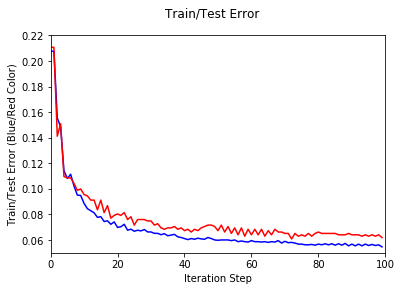

In [6]:
model.plot_train_test_error()

### Plot of final ROC curve

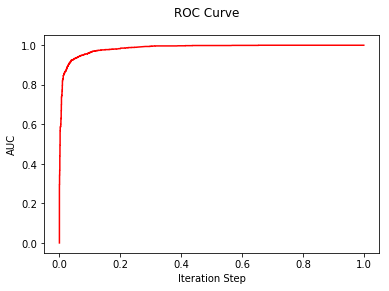

In [7]:
model.plot_ROC_curve()

### Plot of local round error which reduces after each iteration

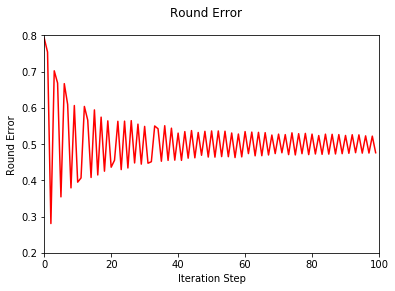

In [8]:
model.plot_round_error()